# Clasificando latídos cardíacos

https://www.kaggle.com/datasets/shayanfazeli/heartbeat/code

Frecuencia de muestreo: $360 \frac{muestras}{segundo}$

Descomentar y ejecutar la siguiente celda para descargar el set de datos

In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("shayanfazeli/heartbeat")

# print("Path to dataset files:", path)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
import numpy as np

# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from Layers import Input, Dense
from ANN import NeuralNetwork
from loss_functions import mse, mse_prima
from activationsFunctions import *

Cargamos los datos de entrenamiento y de testeo.

In [3]:
train = pd.read_csv('dataset\\mitbih_train.csv', header=None)
test = pd.read_csv('dataset\\mitbih_test.csv', header=None)

print(train.shape, test.shape)

(87554, 188) (21892, 188)


Podemos ver que tenemos 87554 datos de entrenamiento y 21892 datos de testeo.

Ahora bien, según el sitio que provee los datos, la última columna de los csv contienen las etiquetas correspondientes al tipo de latído cardíaco para una observación en particular.

Los valores de las etiquetas y el tipo de latidos, son:

- 0: "Normal",
- 1: "Artial Premature",
- 2: "Premature ventricular contraction",
- 3: "Fusion of ventricular and normal",
- 4: "Fusion of paced and normal": Los latidos de fusión ventricular pueden ocurrir cuando el ritmo natural del corazón y el impulso de un marcapasos coinciden para activar la misma parte de un ventrículo al mismo tiempo.

Veamos cuantos datos de cada uno tenemos.

In [9]:
train.iloc[:, 187].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

In [10]:
test.iloc[:, 187].value_counts()

187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

La mayoría de los datos corresponden a latidos normales, seguidos por los latidos de fusión ventricular.

In [11]:
data_train, labels_train = train.iloc[:, :187].values, train.iloc[:, 187].values
data_test, labels_test = test.iloc[:, :187].values, test.iloc[:, 187].values

Vamos a generar una función para obtener los datos correspondientes a un sólo tipo de latido

In [28]:
def getHeartbetType(samples, labels, type = 0):
    """
    samples: numpy array 2D con los samples
    labels: numpy array 1D con las etiquetas.
    type: tipo de latido. Es un número entero. 
    """
    filter = labels == type

    return samples[filter], labels[filter]

In [29]:
normal_beats, _ = getHeartbetType(data_train, labels_train, type=0)
fussion_beats, _ = getHeartbetType(data_train, labels_train, type=4)

Vamos a graficar algunos latídos cardíacos normales.

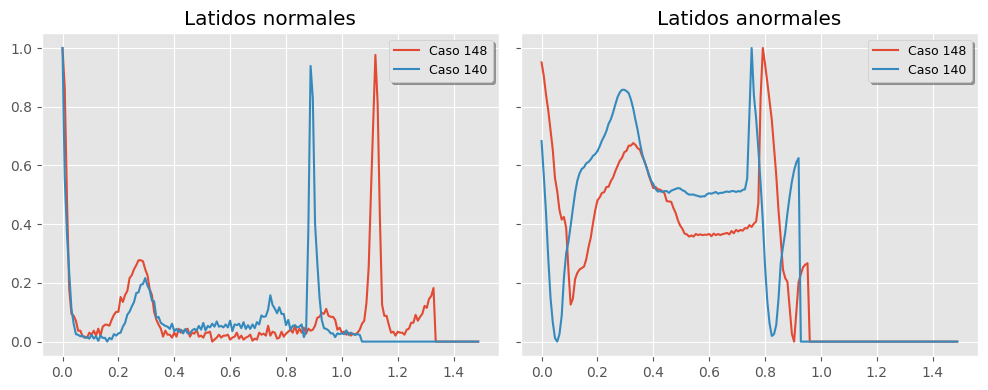

In [39]:
fs = 125
ejet = np.arange(0, data_train.shape[1])*1/fs
index = [148, 140]
# index = np.random.randint(0, data_train.shape[1], 2)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax[0].plot(ejet, data_train[index[0],:],label=f"Caso {index[0]}")
ax[0].plot(ejet, data_train[index[1], :], label=f"Caso {index[1]}")
ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
ax[0].set_title("Latidos normales")

ax[1].plot(ejet, fussion_beats[index[0], :], label=f"Caso {index[0]}")
ax[1].plot(ejet, fussion_beats[index[1], :], label=f"Caso {index[1]}")
ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
ax[1].set_title("Latidos anormales")

plt.tight_layout()
plt.show()

## Generando datos de entrenamiento y testeo

Vamos a tomar los datos correspondientes a latidos normales y de fusión ventricular, es decir, etiquetas $0$ y $4$.

Usaremos estas para entrenar una red y clasificar latidos normales vs enfermos.

In [49]:
##primero usamos getHeartbetType sobre los datos de entrenamiento y testeo

normal_train_data, normal_train_labels = getHeartbetType(data_train, labels_train, type=0)
normal_test_data, normal_test_labels = getHeartbetType(data_test, labels_test, type=0)

anormal_train_data, anormal_train_labels = getHeartbetType(data_train, labels_train, type=4)
anormal_test_data, anormal_test_labels = getHeartbetType(data_test, labels_test, type=4)

##reemplazo los valores 4 por 1 en las etiquetas
fussion_beats_train_labels = np.ones(anormal_train_labels.shape)
fussion_beats_test_labels = np.ones(anormal_test_labels.shape)

Ahora formo X_train, y_train, X_test e y_test concatenando los datos anteriores.

In [50]:
#Ahora formo X_train, y_train, X_test e y_test concatenando los datos anteriores.
X_train = np.concatenate((normal_train_data, anormal_train_data))
y_train = np.concatenate((normal_train_labels, fussion_beats_train_labels))
y_train = y_train.reshape(-1, 1)
X_test = np.concatenate((normal_test_data, anormal_test_data))
y_test = np.concatenate((normal_test_labels, fussion_beats_test_labels))
y_test = y_test.reshape(-1, 1)

### Normalizando los datos

A continuación vamos a estandarizar los datos. Esto quiere decir, que haremos que nuestros datos tengan media 0 y desvío estándar 1.

Utilizaremos el módulo [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [53]:
X_train.mean(), X_train.std()

(0.16914693115827462, 0.2230739647170512)

In [54]:
##uso StandardScaler para standardizar los datos
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [55]:
np.round(X_train.mean(), 2), np.round(X_train.std(), 2)

(-0.0, 1.0)

**IMPORTANTE**: La variable *scaler* contiene la media y el desvío estándar necesarios para ajustar nuevos datos. Estos valores han sido sacados de los datos de entrenamiento.

Usaremos este scaler más adelante en nuestros datos de testeo.

## Generando nuestra red

A continuación vamos a usar nuestra clase *ANN* para armar una red que nos permita clasificar latidos cardíacos.

La arquitectura de la red será:

- Input Layer con 187 nodos.
- Capa oculta 1 con 128 nodos, con Relu.
- Capa oculta 2 con 64 nodos, con Relu.
- Capa oculta 3 con 32 nodos, con Relu.
- Capa de salida con 1 nodo, con Sigmoid.

In [57]:
input_layer = Input(n_neuronas=(187,))

hidden_layer1 = Dense(ninputs=187, noutputs=128, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer1",random_seed=0)

hidden_layer2 = Dense(ninputs=128, noutputs=64, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer2",random_seed=0)

hidden_layer3 = Dense(ninputs=64, noutputs=32, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer3",random_seed=0)

output_layer = Dense(ninputs=32, noutputs=1, activation=sigmoid, activation_prima=sigmoid_prima,
                     weights_init="uniform", bias_init="zeros", name="OutputLayer",random_seed=0)

layers = [input_layer,hidden_layer1,hidden_layer2,hidden_layer3,output_layer] ##lista con mis capas
nn1 = NeuralNetwork(layers) ##creamos la red

nn1.use(loss=mse, loss_prima=mse_prima) ##definimos la función de pérdida

### Entrenando la red

In [58]:
nn1.train(X_train, y_train, learning_rate=0.01, epochs=61, tolerancia=1e-3, imprimir_cada=10)

Época 0, MSE: [5.90187161e-08]
Época 10, MSE: [0.04545455]
Época 20, MSE: [5.71893214e-07]
Época 30, MSE: [2.62563066e-07]
Época 40, MSE: [6.44867452e-07]
Época 50, MSE: [3.28806189e-06]
Época 60, MSE: [9.48407559e-07]


In [60]:
data_clasificada = nn1.classify(scaler.transform(X_test))
data_clasificada

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [61]:
nn1.predict(scaler.transform(X_test))

array([[7.00109950e-07],
       [8.55710914e-13],
       [4.16930853e-05],
       ...,
       [2.65875762e-01],
       [9.99951230e-01],
       [1.00000000e+00]])

## Analizando la performance de la red

In [62]:
##metricas
accuracy = accuracy_score(y_test, data_clasificada)
precision = precision_score(y_test, data_clasificada)
recall = recall_score(y_test, data_clasificada)
f1 = f1_score(y_test, data_clasificada)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")

Accuracy: 0.99
Precision: 0.99
Recall: 0.94
F1: 0.97


### Matriz de confusión

In [63]:
##matriz de confusión
tp = np.sum((y_test==1) & (data_clasificada==1))
tn = np.sum((y_test==0) & (data_clasificada==0))
fp = np.sum((y_test==0) & (data_clasificada==1))
fn = np.sum((y_test==1) & (data_clasificada==0))

mc = np.array([[tp,fn],[fp,tn]])
#normalizo la matriz de confusión. La normalización se hace dividiendo cada elemento por la suma de la columna
mc_norm = mc/mc.sum(axis=0)

print(mc)
print(mc_norm.round(3)) 

[[ 1519    89]
 [   20 18098]]
[[0.987 0.005]
 [0.013 0.995]]


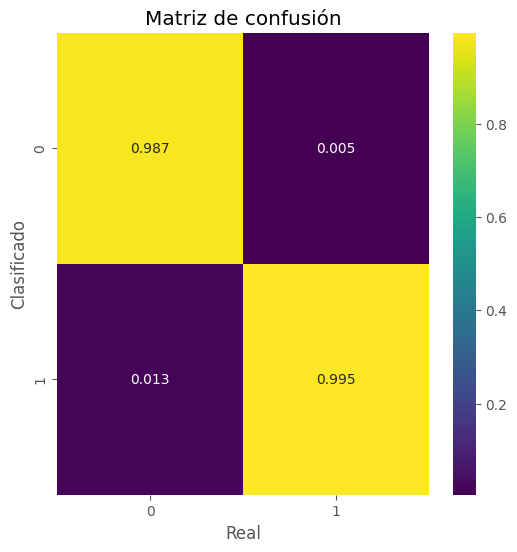

In [64]:
plt.figure(figsize=(6,6))
sns.heatmap(mc_norm.round(3), annot=True, cmap='viridis', fmt='g')
plt.xlabel('Real')
plt.ylabel('Clasificado')
plt.title('Matriz de confusión')
plt.show() 

### Testeando la red para clasificación multiclase

In [65]:
normal_X_train, normal_y_train = getHeartbetType(data_train, labels_train, type=0)
fussion_X_train, fussion_y_train = getHeartbetType(data_train, labels_train, type=4)
atrial_X_train, atrial_y_train = getHeartbetType(data_train, labels_train, type=2)

##testeo
normal_X_test, normal_y_test = getHeartbetType(data_test, labels_test, type=0)
fussion_X_test, fussion_y_test = getHeartbetType(data_test, labels_test, type=4)
atrial_X_test, atrial_y_test = getHeartbetType(data_test, labels_test, type=2)

##uno los datos de entrenamiento
X_train_multiclass = np.concatenate((normal_X_train, fussion_X_train, atrial_X_train))
y_train_multilabel = np.concatenate((normal_y_train, fussion_y_train, atrial_y_train))
y_train_multilabel = y_train_multilabel.reshape(-1, 1)
##uno los datos de testeo
X_test = np.concatenate((normal_X_test, fussion_X_test, atrial_X_test))
y_test = np.concatenate((normal_y_test, fussion_y_test, atrial_y_test))
y_test = y_test.reshape(-1, 1)


In [68]:
y_train_multilabel

array([[0.],
       [0.],
       [0.],
       ...,
       [2.],
       [2.],
       [2.]])

In [69]:

##utilizo onehotencoder para codificar las etiquetas
encoder = OneHotEncoder()
y_train_multilabel = encoder.fit_transform(y_train_multilabel)

##uso StandardScaler para standardizar los datos
scaler = StandardScaler()
scaler.fit(X_train_multiclass)

X_train_multiclass = scaler.transform(X_train_multiclass)

In [72]:
# y_train_multilabel.toarray()

In [73]:
input_layer = Input(n_neuronas=(187,))

hidden_layer1 = Dense(ninputs=187, noutputs=128, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer1",random_seed=0)

hidden_layer2 = Dense(ninputs=128, noutputs=64, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer2",random_seed=0)

hidden_layer3 = Dense(ninputs=64, noutputs=32, activation=relu, activation_prima=relu_prima,
                      weights_init="uniform", bias_init="zeros", name="DenseLayer3",random_seed=0)

output_layer = Dense(ninputs=32, noutputs=3, activation=sigmoid, activation_prima=sigmoid_prima,
                     weights_init="uniform", bias_init="zeros", name="OutputLayer",random_seed=0)

layers = [input_layer,hidden_layer1,hidden_layer2,hidden_layer3,output_layer] ##lista con mis capas
nn2 = NeuralNetwork(layers) ##creamos la red

nn2.use(loss=mse, loss_prima=mse_prima) ##definimos la función de pérdida

In [74]:
##entrenamos la red
nn2.train(X_train_multiclass, y_train_multilabel, learning_rate=0.01, epochs=50, tolerancia=1e-3, imprimir_cada=10)

Época 0, MSE: [[1.66654144e-01 2.22222119e-01 1.08396127e-09]]
Época 10, MSE: [[0.10319712 0.11129006 0.22222222]]
Época 20, MSE: [[0.00049669 0.05555765 0.11111111]]
Época 30, MSE: [[1.19235301e-03 2.08418982e-05 5.55555555e-02]]
Época 40, MSE: [[0.00012624 0.00073246 0.05555556]]


In [78]:
##clasificamos
data_clasificada = nn2.classify(scaler.transform(X_test))
probas = nn2.predict(scaler.transform(X_test))
probas

array([[9.99868023e-01, 1.96773540e-05, 1.63807260e-10],
       [9.99992649e-01, 2.55097219e-08, 6.04032371e-13],
       [9.99978897e-01, 4.02435339e-06, 4.21932304e-11],
       ...,
       [9.99999974e-01, 1.30823055e-09, 2.32670787e-10],
       [1.10869486e-07, 9.99999993e-01, 2.05921514e-14],
       [6.99815659e-09, 9.99999888e-01, 5.12219416e-32]])

In [1]:
##me quedo con los indices de probas donde todos los elementos son ceros.
##tener en cuenta que probas es un array de 3 columnas, una por cada muestra. Es decir, (muestras, 3)

indices = np.where((data_clasificada == 0).all(axis=1))[0]
indices.shape

NameError: name 'np' is not defined

Tenemos $1616$ datos que no pudieron ser clasificados en ninguna de las tres clases. 

Veamos algunos valores de probabilidad obtenidos para esos casos.

In [81]:
np.round(probas[indices[:4]], 4)

array([[0.3139, 0.2271, 0.    ],
       [0.2986, 0.017 , 0.    ],
       [0.0043, 0.2217, 0.    ],
       [0.4158, 0.    , 0.    ]])

Si observamos lo anterior, vemos que los valores de retornados para cada clase están por debajo del umbral de clasificación.

¿Qué podríamos hacer? En principio varias cosas, pero vamos a trabajar algunas.

1. Tomar aquellas muestras que tengan todos ceros y eliminarlos de mis datos clasificados.
2. Hacer $1$ la la columna que contenga el mayor valor para una muestra determinada.
3. Combinación de 1 y 2.
4. Cambiar la función de activación a la salida de la red.

En este caso, usaremos la opción 1 por simplicidad.

In [90]:
##elimino los indices en data_clasificada y en y_test para poder comparar
data_clasificada_filtrada = np.delete(data_clasificada, indices, axis=0)
y_test_filtrada = np.delete(y_test, indices, axis=0)

##decodifico data_clasificada_filtrada
data_clasificada_filtrada = encoder.inverse_transform(data_clasificada_filtrada)

In [91]:
##obtengo las métricas	
accuracy = accuracy_score(y_test_filtrada, data_clasificada_filtrada)
precision = precision_score(y_test_filtrada, data_clasificada_filtrada, average="weighted")
recall = recall_score(y_test_filtrada, data_clasificada_filtrada, average="weighted")
f1 = f1_score(y_test_filtrada, data_clasificada_filtrada, average="weighted")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")

Accuracy: 0.99
Precision: 0.98
Recall: 0.99
F1: 0.98


c:\Users\Lucas\miniconda3\envs\bcihack2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [88]:
##obtengo la matriz de confusión entre y_test_filtrada y data_clasificada_filtrada
mc = confusion_matrix(y_test_filtrada, data_clasificada_filtrada)
mc_norm = mc/mc.sum(axis=0)*100
##reemplazo los valores NaN por 0
mc_norm = np.nan_to_num(mc_norm)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_17936\1116122643.py:3: RuntimeWarning: invalid value encountered in divide
  mc_norm = mc/mc.sum(axis=0)*100


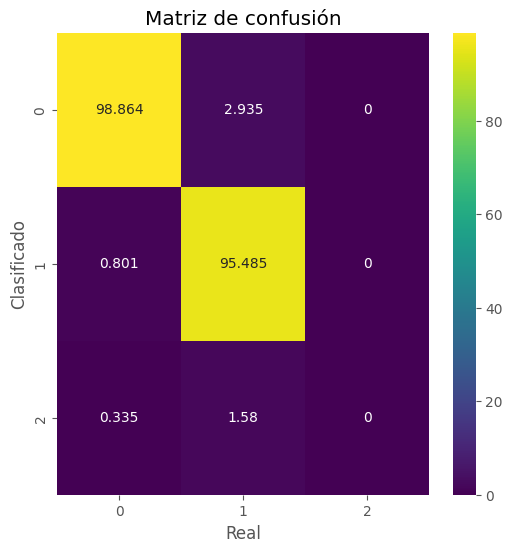

In [89]:
##grafico la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(mc_norm.round(3), annot=True, cmap='viridis', fmt='g')
plt.xlabel('Real')
plt.ylabel('Clasificado')
plt.title('Matriz de confusión')
plt.show()